# Mixture density networks

This notebook reproduce the "simple inversion problem" in section 5 of Bishop 1994
(https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) using PyTorch.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Generate the simulations.

In [2]:
t = np.random.random(1000)
x = t + 0.3*np.sin(2*np.pi*t)
x += np.random.uniform(-0.1, 0.1, size=len(t))

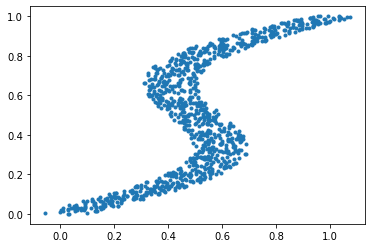

In [3]:
plt.plot(x, t, '.')

# Defining and training the network

In [4]:
import torch
from torch import nn, optim

import torch.nn.functional as F
from torch.distributions import Normal

In [5]:
class MDN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, 20), nn.Tanh(), nn.Linear(20, 9))
        
    def forward(self, x):
        X = self.net(x.unsqueeze(1))
        X = X.reshape(len(X), 3, -1)
        alpha = F.softmax(X[:,0], dim=1)
        mu = X[:,1]
        
        # Different from the original paper.
        sig = torch.exp(X[:,2])

        dist = Normal(mu, sig)
        
        return alpha, dist

    def log_prob(self, x, y):
        """Evaluates the logarithmic probability."""
        
        alpha, dist = self.forward(x)
        
        y = y.unsqueeze(1).repeat((1,3))
        log_prob_all = torch.log(alpha) + dist.log_prob(y)
        log_prob = torch.logsumexp(log_prob_all, 1)
        
        return log_prob

In [10]:
t = torch.Tensor(t)
x = torch.Tensor(x)
net = MDN()

In [18]:
# Probably overkill, but it was converging slower than expected.
optimizer = optim.Adam(net.parameters(), lr=1e-4)
for i in range(5000):
    optimizer.zero_grad()
    loss = -net.log_prob(x, t).mean()
    loss.backward()
    optimizer.step()
    
    if not i % 1000:
        print(i, loss.item())

0 -1.0446105003356934
1000 -1.0588819980621338
2000 -1.065325140953064
3000 -1.0691338777542114
4000 -1.0726940631866455


# Evaluation
The default number of epoch is not sufficient. You should probably
later go back and train more.

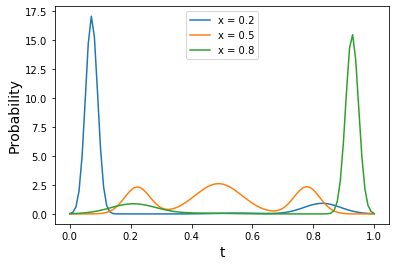

In [20]:
for xval in [0.2, 0.5, 0.8]:
    x1 = xval*torch.ones(100)
    t1 = torch.linspace(0, 1, 100)
    log_prob = net.log_prob(x1, t1)
    prob = torch.exp(log_prob)

    plt.plot(t1.numpy(), prob.detach().cpu().numpy(), label=f'x = {xval}')
    
plt.legend()
plt.xlabel('t', size=14)
plt.ylabel('Probability', size=14)

plt.savefig('bishop_repod_fig7.png')